In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/test.csv')
ss = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
# 1.0 Introduction of metadata
# 1.0 모든 데이터에 대한 소개
data = []
for feature in train.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    # 진짜 찾고 있던 방식 : column명안에 어떤 str이 포함되어있는지에 따라
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif train[feature].dtype == float or isinstance(train[feature].dtype, float):
        type = 'real'
    elif train[feature].dtype == int:
        type = 'integer'
        
    preserve = True
    if feature == 'id':
        preserve = False
        
    dtype = train[feature].dtype
    category = 'none'
    
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    feature_dictionary = {'varname' : feature,
                         'use' : use,
                         'type': type,
                         'preserve' : preserve,
                         'dtype' : dtype,
                         'category' : category
                         }
    data.append(feature_dictionary)

md = pd.DataFrame(data, columns = ['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
md.set_index('varname', inplace=True)
md

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [5]:
pd.DataFrame({'count' : md.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


Text(0.5, 1.0, 'Count plot - target')

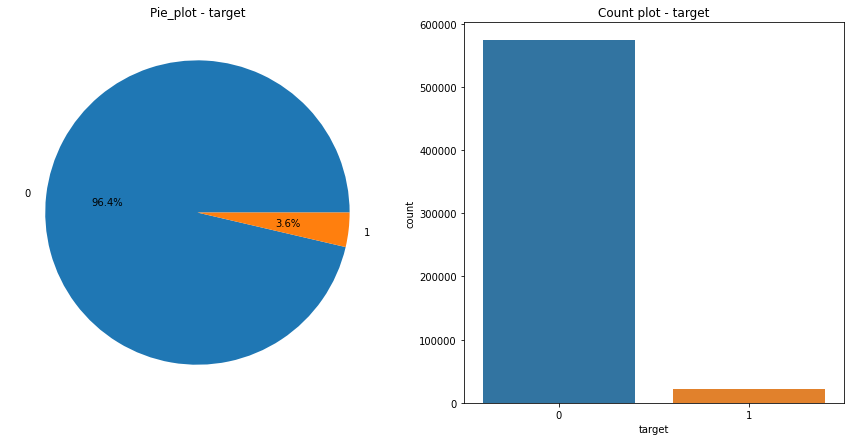

In [6]:
# 1.1 Inspection of target column should have to predict

f, ax = plt.subplots(1, 2, figsize = (15, 7))
train['target'].value_counts().plot.pie(autopct='%1.1f%%', ax = ax[0])
ax[0].set_title('Pie_plot - target')
ax[0].set_ylabel('')
sns.countplot('target', data=train, ax=ax[1])
ax[1].set_title('Count plot - target')

Inspection of Target Column

Unbalanced ratio (96 : 4) -> have to undersampling or oversampling to balance

In [7]:
# 1.2 Inspection of real type columns

var = md[(md.type == 'real') & (md.preserve)].index
train[var].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


ps_reg_03, ps_car_12, ps_car_14 have missing values(NaN)

<Figure size 432x288 with 0 Axes>

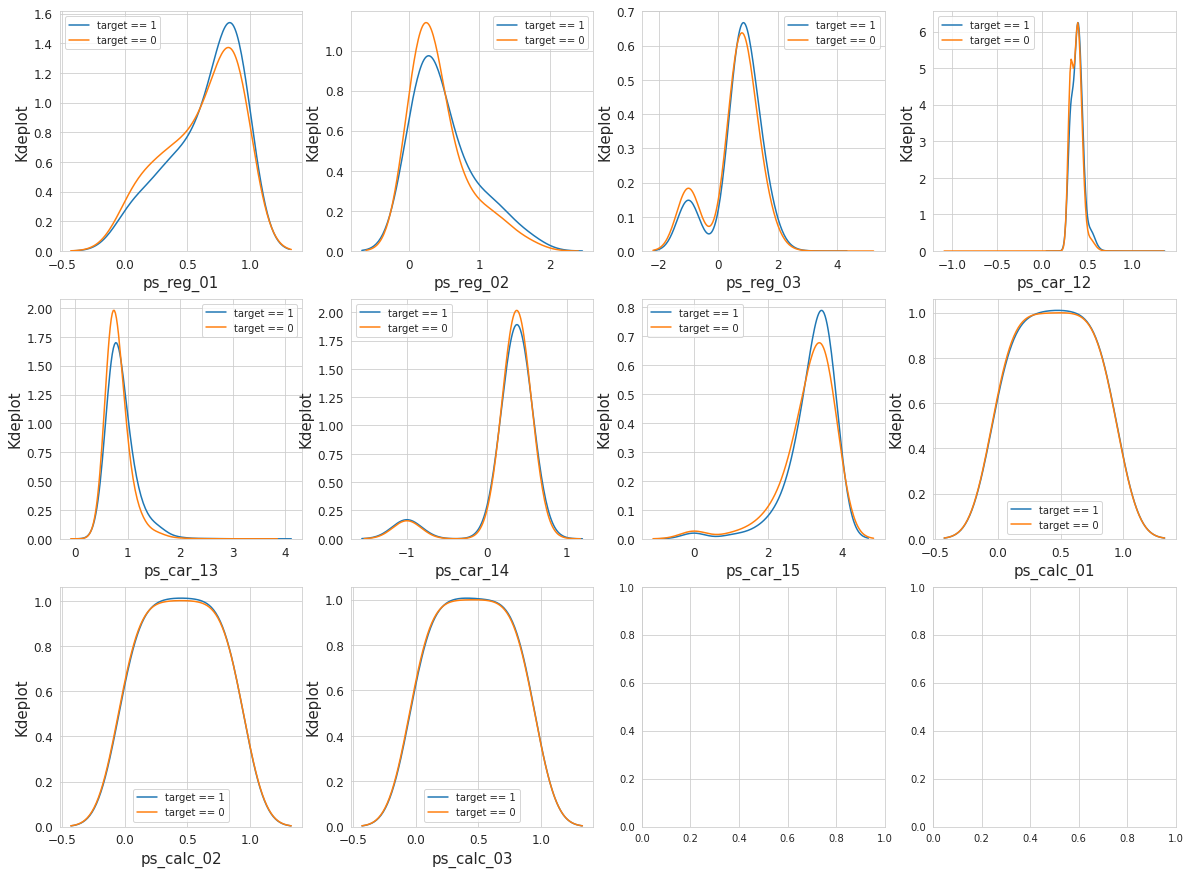

In [8]:
# 1.1.1 kdeplot of real type columns divided by target

i = 0
t1 = train.loc[train['target'] != 0]
t2 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
f, ax = plt.subplots(3, 4, figsize=(20, 15))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target == 1')
    sns.kdeplot(t2[feature], bw=0.5, label='target == 0')
    plt.ylabel('Kdeplot', fontsize=15)
    plt.xlabel(feature, fontsize=15)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='best')
plt.show()

ps_reg_02, ps_car_13, ps_car_15 shows the most different distributions between sets of values associated with target=0 and target=1.

??

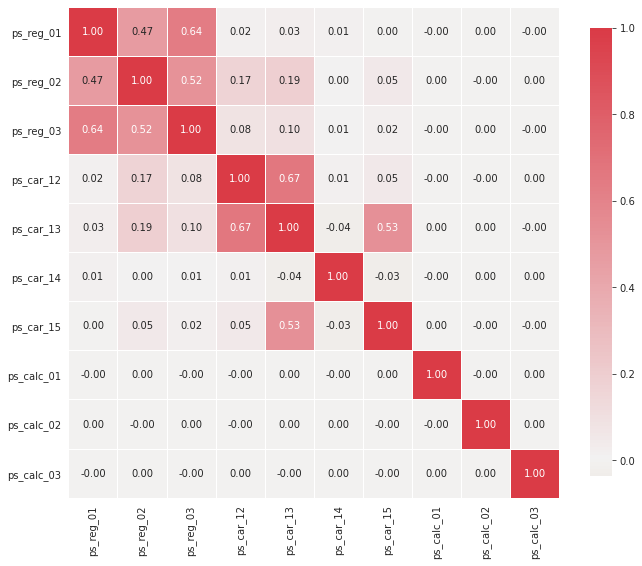

In [9]:
# 1.1.2 correlations of real type columns

correlations = train[var].corr()
cmap = sns.diverging_palette(50, 10, as_cmap = True)

f, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
plt.show()

visualize the correlations of real type columns

1. ps_reg_01 with ps_reg_02 (0.47)
2. ps_reg_01 with ps_reg_03 (0.64)
3. ps_reg_02 with ps_reg_03 (0.52)
4. ps_car_12 with ps_car_13 (0.67)
5. ps_car_13 with ps_car_15 (0.53)

In [10]:
# 1.2 Inspection of Binary features
var = md[(md.type == 'binary') & (md.preserve)].index
train[var].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are any missing values(NaN) = clean data

<Figure size 432x288 with 0 Axes>

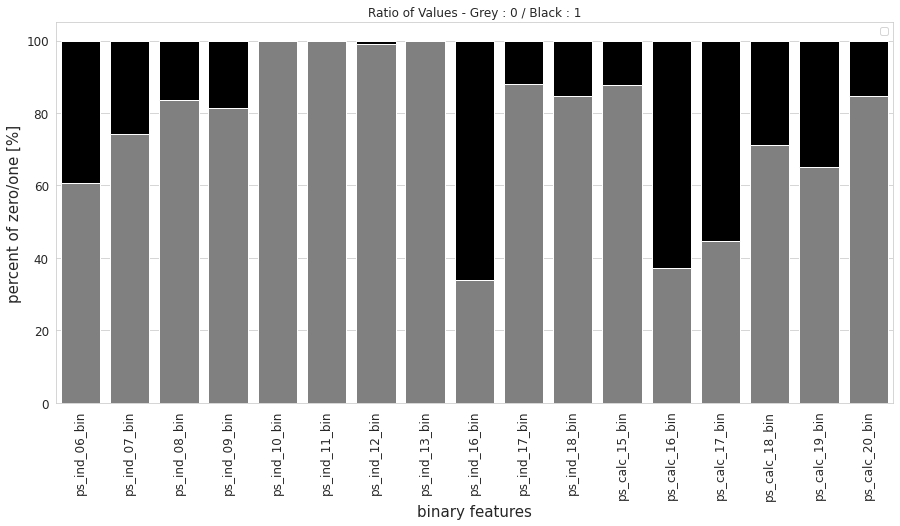

In [11]:
# 1.2.1 Visualize Binary features by using barplot
bin_col = [col for col in train.columns if '_bin' in col]
zero = []
one = []
for col in bin_col:
    zero.append((train[col]==0).sum() / train.shape[0] * 100)
    one.append((train[col]==1).sum() / train.shape[0] * 100)
plt.figure()
f, ax = plt.subplots(figsize = (15, 7))

ax.set_title('Ratio of Values - Grey : 0 / Black : 1')
p1 = sns.barplot(ax=ax, x=bin_col, y=zero, color='grey')
p2 = sns.barplot(ax=ax, x=bin_col, y=one, bottom = zero, color='black')

plt.ylabel('percent of zero/one [%]', fontsize=15)
plt.xlabel('binary features', fontsize = 15)

locs,labels = plt.xticks()

plt.setp(labels, rotation = 90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

At ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin, there are almost any zero values

At ps_ind_16_bin, ps_calc_16_bin, ps_calc_17_bin, ratio of 0 is more than 60%

<Figure size 432x288 with 0 Axes>

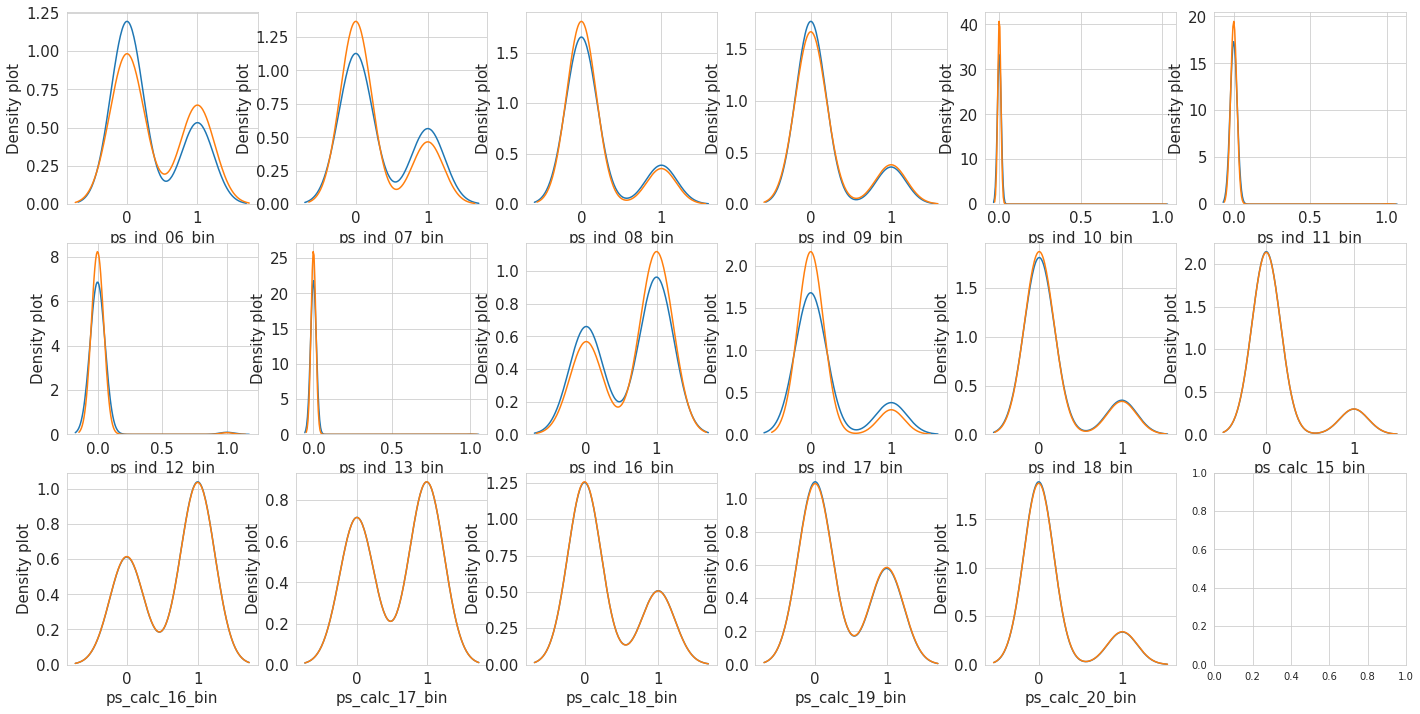

In [12]:
# 1.2.2 density plot using by binary type columns

var = md[(md.type == 'binary') & (md.preserve)].index
var = [col for col in train.columns if '_bin' in col]
i = 0
t1 = train.loc[train['target'] != 0]
t0 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,6,figsize=(24, 12))

for feature in var:
    i += 1
    plt.subplot(3,6,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel('Density plot', fontsize=15)
    plt.xlabel(feature, fontsize=15)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=15)
    
plt.show();

At ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin, there are high imbalance between (target == 0) and (target == 1)

08, 09 have small imbalance either

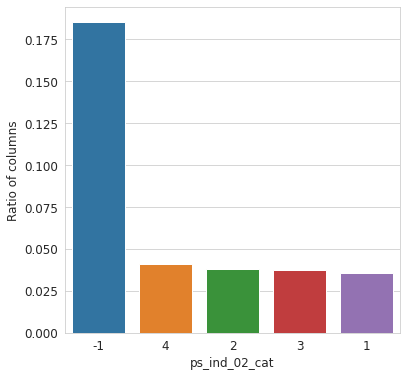

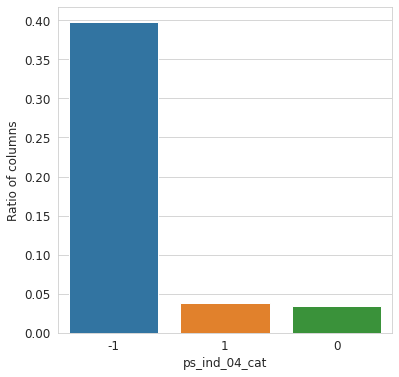

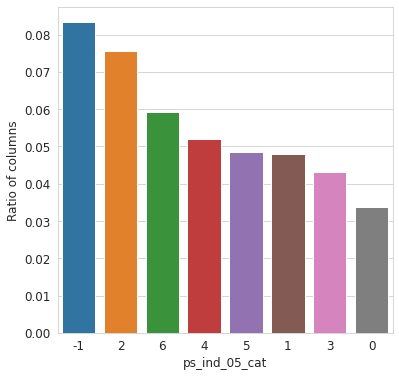

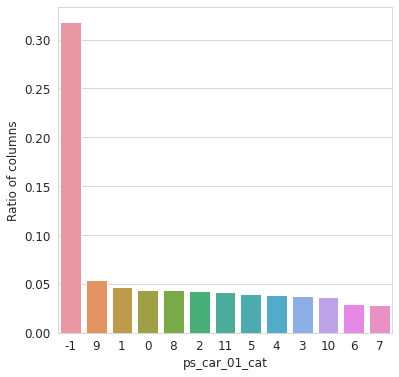

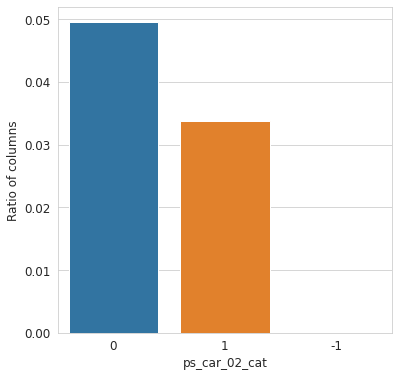

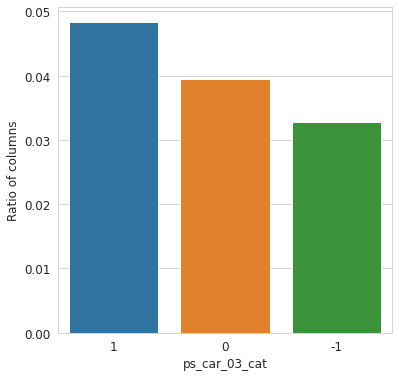

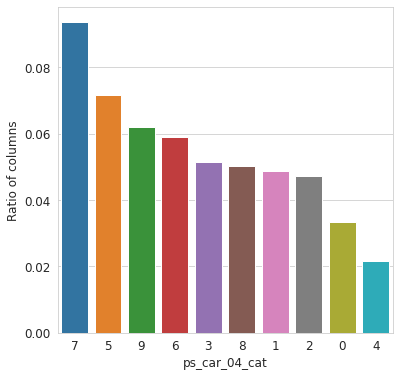

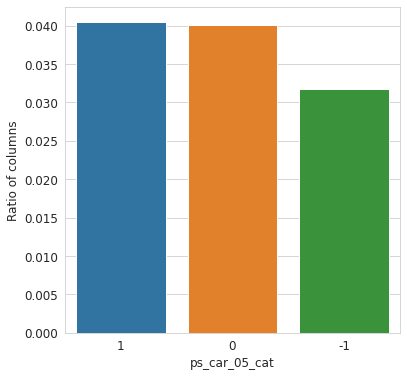

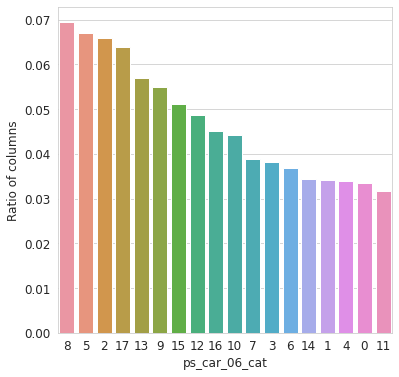

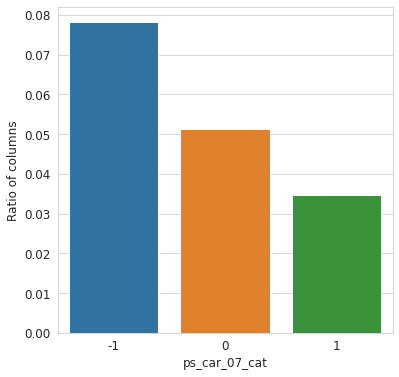

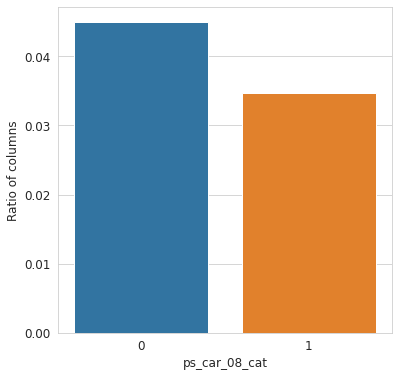

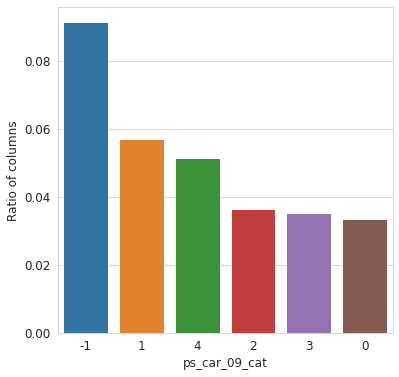

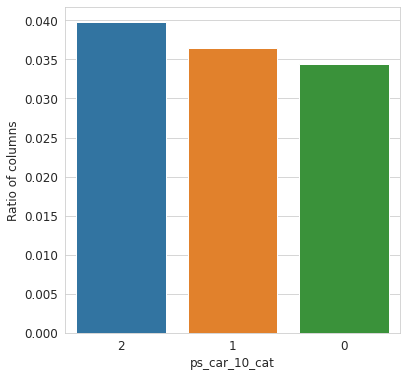

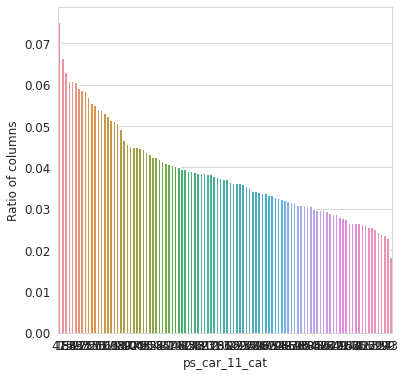

In [13]:
# 1.3.0 Inspection of categorical type columns

var = md[(md.type == 'categorical') & (md.preserve)].index

for feature in var:
    f, ax = plt.subplots(figsize = (6, 6))
    cat_perc = train[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by = 'target', ascending=False, inplace=True)
    
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Ratio of columns', fontsize = 12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

<Figure size 432x288 with 0 Axes>

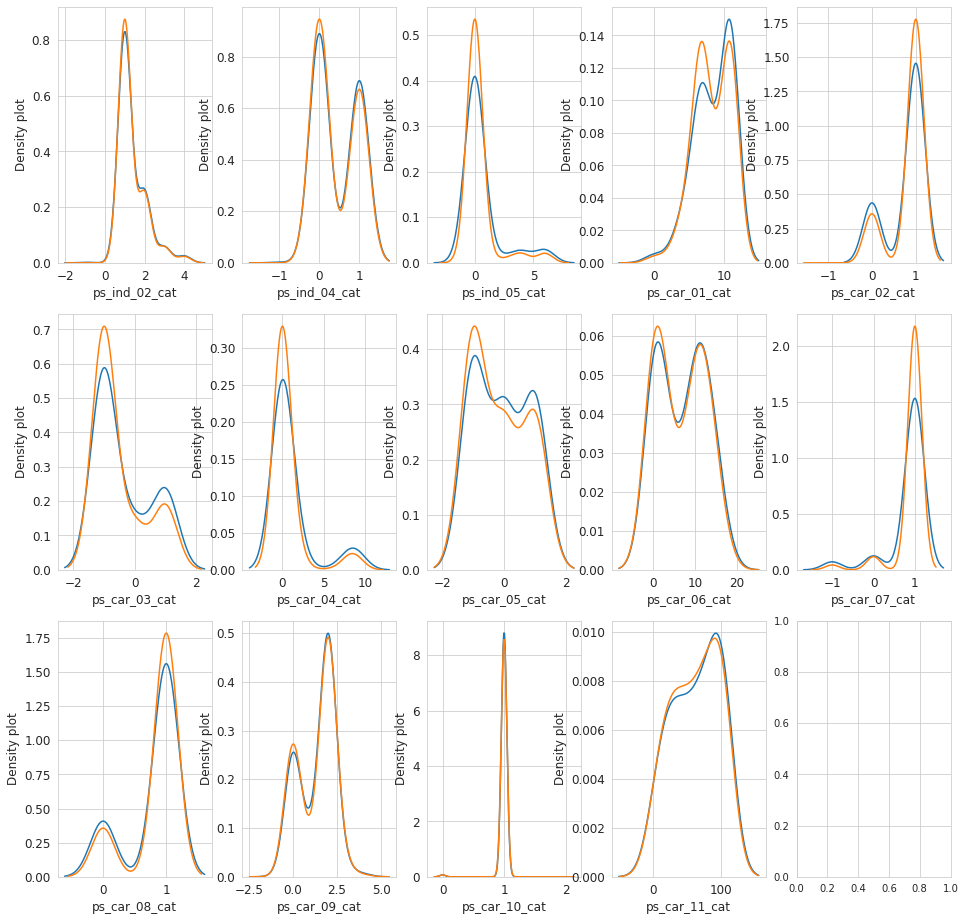

In [14]:
# 1.3.1 Density plot of 
i = 0
t1 = train.loc[train['target'] != 0]
t0 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,5,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(3,5,i)
    sns.kdeplot(t1[feature], bw=0.5,label= "target == 1")
    sns.kdeplot(t0[feature], bw=0.5,label= "target == 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    
plt.show();

At ps_car_03_cat, ps_car_05_cat, there are different density plot between target = 0 and target = 1

At ps_ind_05_cat, ps_car_01_cat, ps_car_02_cat, ps_car_07_cat, I think there shows differet density plot between plot 

<Figure size 432x288 with 0 Axes>

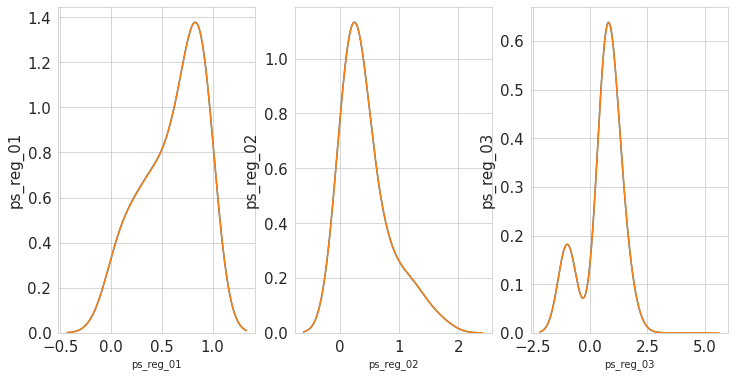

In [15]:
# ★★★★
# 2.0 Inspection of data unbalance between test and train set
# 2.0 한번도 생각하지 못했던 test와 train set간의 data 불균형에 대한 고찰 (하나 얻어갑니다)

var_r = md[(md.category == 'registration') & (md.preserve)].index

sns.set_style('whitegrid')

plt.figure()
f, ax = plt.subplots(1, 3, figsize=(12, 6))
i = 0
for feature in var_r:
    i += 1
    plt.subplot(1, 3, i)
    sns.kdeplot(train[feature], bw=0.5, label='train')
    sns.kdeplot(test[feature], bw=0.5, label='test')
    plt.ylabel(feature, fontsize = 15)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=15)
    
plt.show()

About registration category data, ratio of test and train set is almost equal.

registration category들의 data에 대해서는 test와 train set의 비율이 같다는 것을 볼 수 있다.

<Figure size 432x288 with 0 Axes>

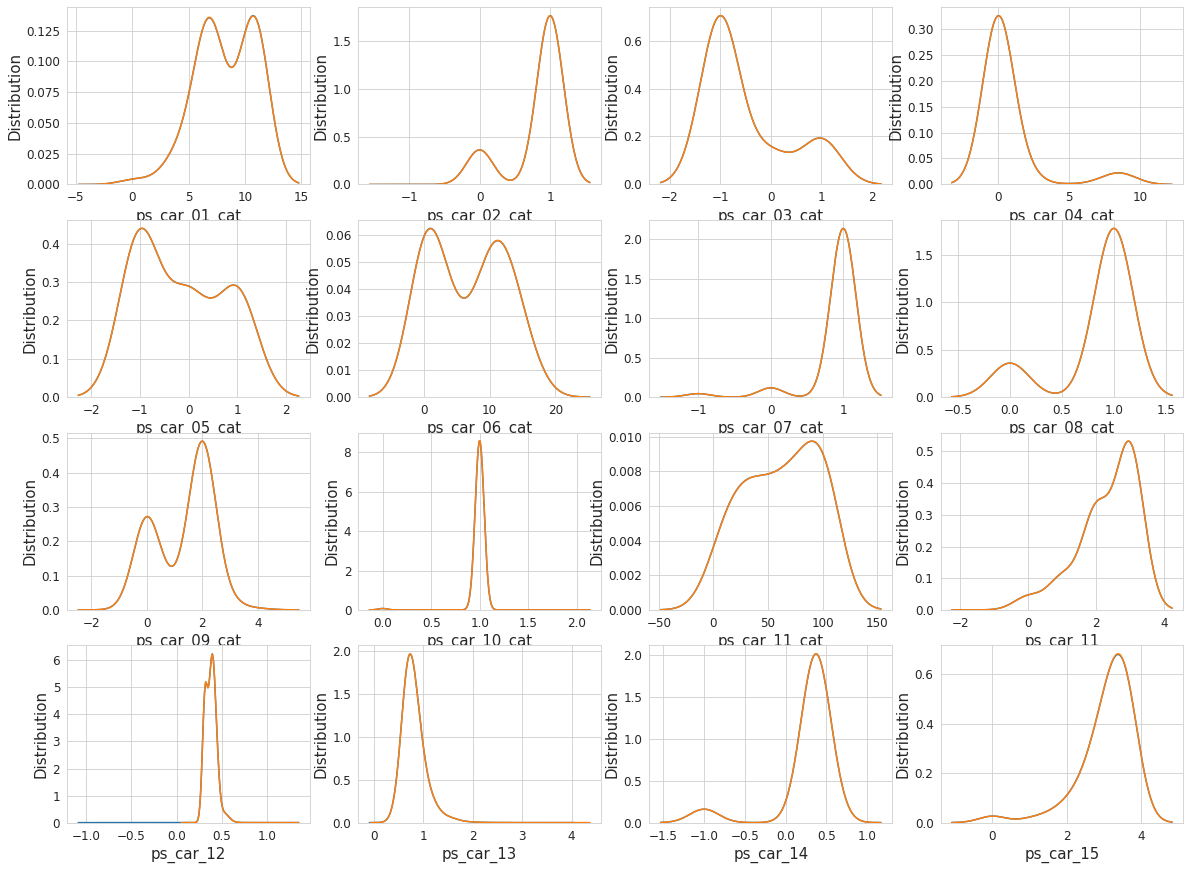

In [16]:
# 2.1 density plot of data its category is car 
var_car = md[(md.category == 'car') & (md.preserve)].index

sns.set_style('whitegrid')

plt.figure()
f, ax = plt.subplots(4, 4, figsize=(20, 15))
i = 0

for feature in var_car:
    i += 1
    plt.subplot(4, 4, i)
    # bw : plot의 bin width 조절
    sns.kdeplot(train[feature], bw=0.5, label='train')
    sns.kdeplot(test[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=15)
    plt.xlabel(feature, fontsize=15)
    locs, labels = plt.xticks()
    plt.tick_params(axis= 'both', which='major', labelsize=12)

plt.show()

At car category datas, there are also equal between train and test set.

car 카테고리에서도 train과 test 데이터 셋의 데이터 분포도는 거의 일치했다.

<Figure size 432x288 with 0 Axes>

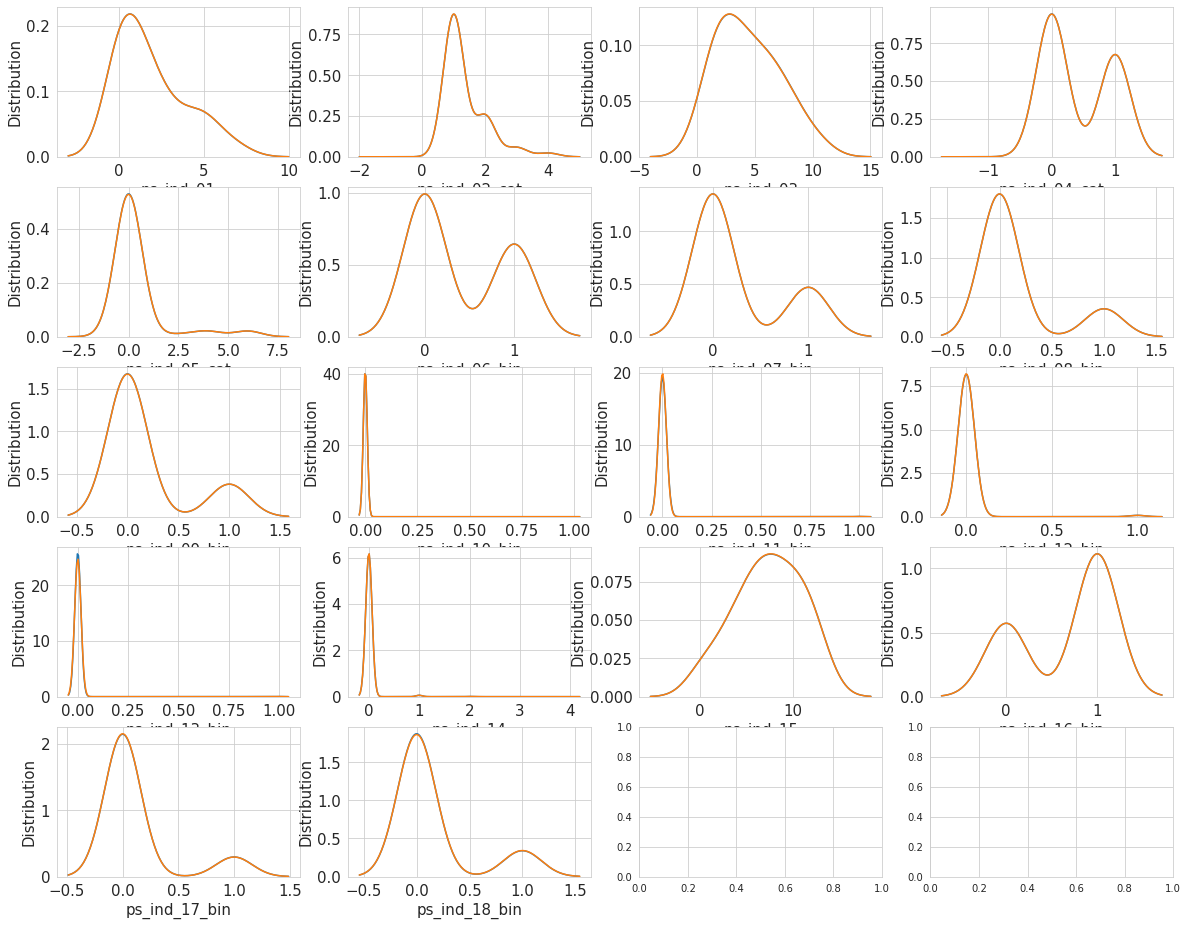

In [17]:
# 2.2 Insepction of data is in individual category between train and test set
# 2.2 individual category인 데이터에 대한 고찰 (train과 test set 사이에서)

var_ind = md[(md.category == 'individual') & (md.preserve)].index

sns.set_style('whitegrid')

plt.figure()
f, ax = plt.subplots(5, 4, figsize = (20, 16))
i = 0
for feature in var_ind:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(train[feature], bw=0.5, label='train')
    sns.kdeplot(test[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=15)
    plt.xlabel(feature, fontsize=15)
    locs, labels = plt.xticks()
    plt.tick_params(axis= 'both', which='major', labelsize=15)
    
plt.show()

At car individual category datas, there are also equal between train and test set.

individual 카테고리에서도 train과 test 데이터 셋의 데이터 분포도는 거의 일치했다.

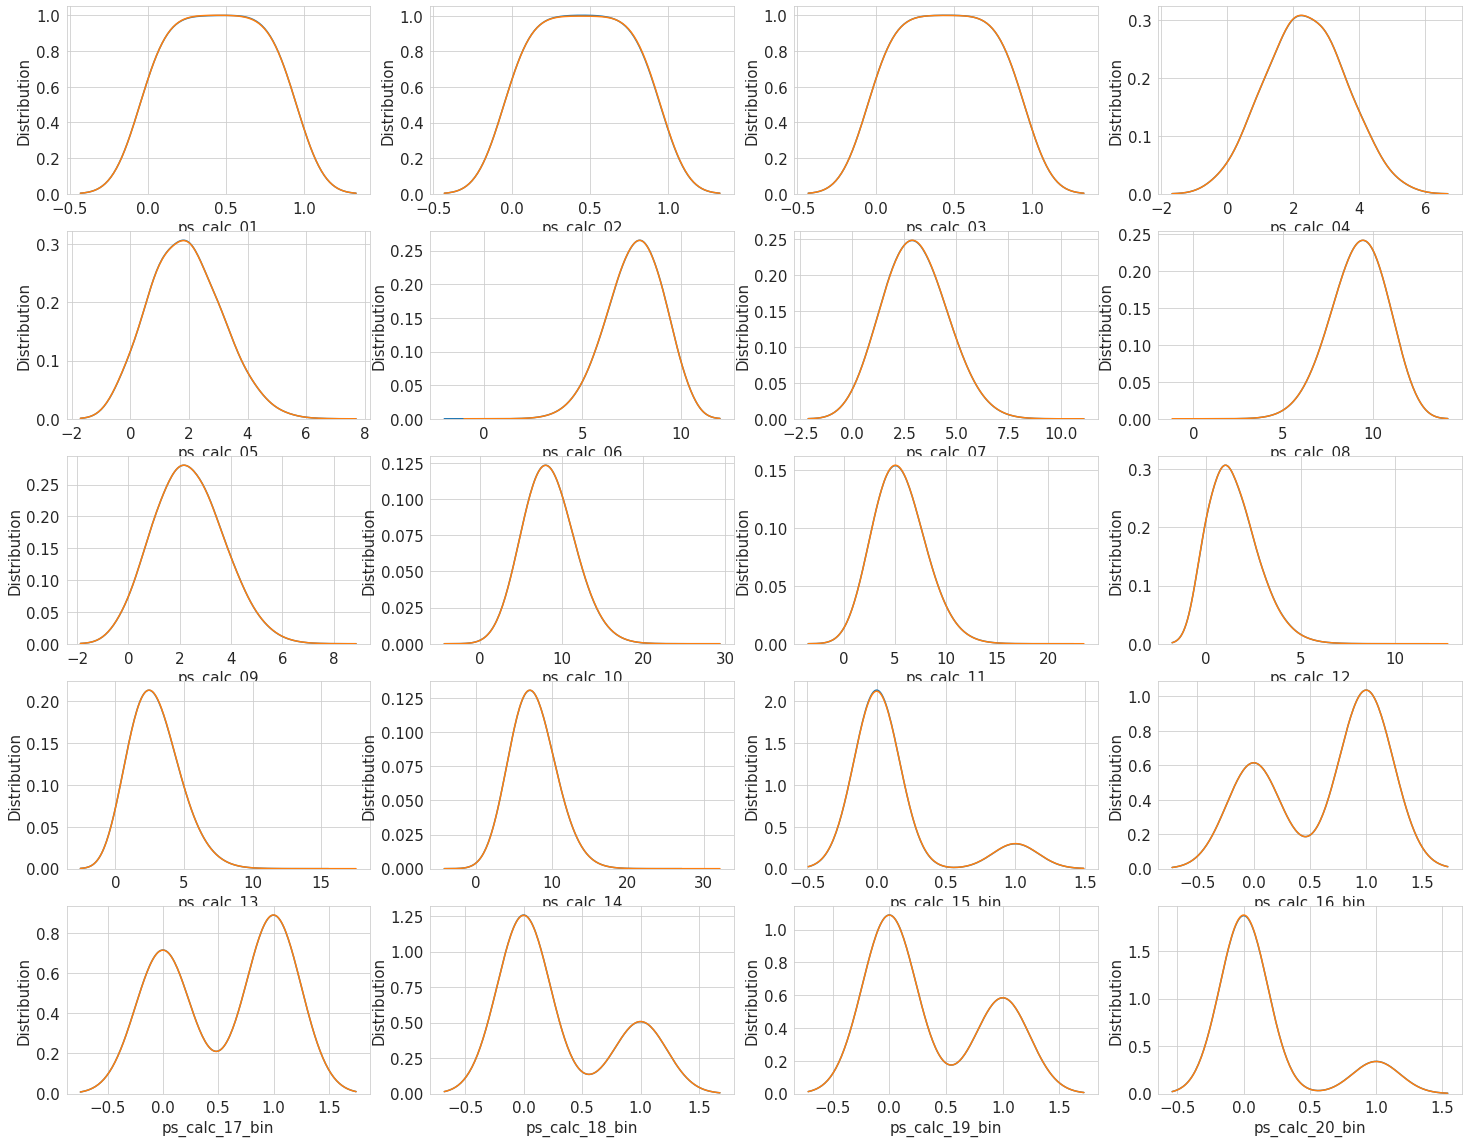

In [18]:
# 2.3 Insepction of data is in calculated category between train and test set
# 2.3 Calculated category인 데이터에 대한 고찰 (train과 test set 사이에서)

var_calc = md[(md.category == 'calculated') & (md.preserve)].index

sns.set_style('whitegrid')

f, ax = plt.subplots(5, 4, figsize=(25, 20))

i = 0
for feature in var_calc:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(train[feature], bw=0.5, label ='train')
    sns.kdeplot(test[feature], bw=0.5, label = 'test')
    plt.ylabel('Distribution', fontsize=15)
    plt.xlabel(feature, fontsize=15)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major',labelsize=15)
    
plt.show()

At calc category datas, there are also equal between train and test set.

calc 카테고리에서도 train과 test 데이터 셋의 데이터 분포도는 거의 일치했다.

In [19]:
# 3.0 Checking NaN values in trainset
# 3.0 train set안에 있는 결측값 여부 확인

nan_tr = []
for feature in train.columns:
    nans = train[train[feature] == -1][feature].count()
    if nans > 0 :
        nan_tr.append(feature)
        nan_percent = nans / train.shape[0]
        
        print(f'Column {feature} has {nans} records {nan_percent:.2f} of 1 with missing values')

Column ps_ind_02_cat has 216 records 0.00 of 1 with missing values
Column ps_ind_04_cat has 83 records 0.00 of 1 with missing values
Column ps_ind_05_cat has 5809 records 0.01 of 1 with missing values
Column ps_reg_03 has 107772 records 0.18 of 1 with missing values
Column ps_car_01_cat has 107 records 0.00 of 1 with missing values
Column ps_car_02_cat has 5 records 0.00 of 1 with missing values
Column ps_car_03_cat has 411231 records 0.69 of 1 with missing values
Column ps_car_05_cat has 266551 records 0.45 of 1 with missing values
Column ps_car_07_cat has 11489 records 0.02 of 1 with missing values
Column ps_car_09_cat has 569 records 0.00 of 1 with missing values
Column ps_car_11 has 5 records 0.00 of 1 with missing values
Column ps_car_12 has 1 records 0.00 of 1 with missing values
Column ps_car_14 has 42620 records 0.07 of 1 with missing values


In [20]:
# 3.1 drop related
cols_drop = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(cols_drop, axis=1)
test = test.drop(cols_drop, axis=1)

In [21]:
# 3.1.1 Too many NaN, so have to drop
cols_drop1 = ['ps_car_03_cat', 'ps_car_05_cat']
test.drop(cols_drop1, axis=1, inplace=True)
train.drop(cols_drop1, axis=1, inplace=True)
md.loc[(cols_drop1), 'keep'] = False

In [22]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [23]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'], test['ps_car_11_cat'],
                                           target=train.target, min_samples_leaf = 100, smoothing=10, noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
md.loc['ps_car_11_cat', 'keep'] = False
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [24]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [25]:
train = train.replace(-1, np.NaN)
test = test.replace(-1, np.NaN)

In [26]:
cat_features = [a for a in train.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(train[column]))
    train = pd.concat([train,temp],axis=1)
    train = train.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(test[column]))
    test = pd.concat([test,temp],axis=1)
    test = test.drop([column],axis=1)

In [27]:
id_test = test['id'].values
target_train = train['target'].values

train = train.drop(['target','id'], axis = 1)
test = test.drop(['id'], axis = 1)

In [28]:
print("Train dataset (rows, cols):",train.shape, "\nTest dataset (rows, cols):",test.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


In [29]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [30]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

In [31]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

In [32]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

In [33]:
y_prediction = stack.fit_predict(train, target_train, test)

Base model 1: fit LGBMClassifier model | fold 1
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63818 [gini]: 0.27636
Base model 1: fit LGBMClassifier model | fold 2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63956 [gini]: 0.27913
Base model 1: fit LGBMClassifier model | fold 3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored.

In [34]:
y_prediction

array([0.07707323, 0.074576  , 0.0714917 , ..., 0.0970807 , 0.06851203,
       0.08468145])

In [35]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)